# Проект: Обучение модели для классификации комментариев на позитивные и негативные (с BERT и без BERT)

## Введение

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.<br>
В вашем распоряжении набор данных с разметкой о токсичности правок.

### Цель исследования

Обучить модель классифицировать комментарии на позитивные и негативные

### Ход исследования

1. Загрузка и подготовка данных;
2. Обучение моделей.

## Загрузка и подготовка данных

### Загрузка данных

In [ ]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import torch
import transformers
import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from tqdm import notebook
from tqdm.notebook import tqdm

In [ ]:
# объявление констант
RANDOM_STATE = 42
TEST_SIZE = 0.1

In [ ]:
# загрузка данных
dataset_url = 'https://code.s3.yandex.net/datasets/toxic_comments.csv'
toxic_comments = pd.read_csv(dataset_url)

In [ ]:
# общий взгляд на данные
toxic_comments.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [ ]:
# просмотр краткого содержания данных
toxic_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [ ]:
# взгляд на уникальные значения некоторых столбцов
print(toxic_comments['Unnamed: 0'].unique())
print(toxic_comments['toxic'].unique())

[     0      1      2 ... 159448 159449 159450]
[0 1]


С признаком 'toxic' все в порядке (1 - токсичный, 2 - не токсичный).<br>
Признак 'Unnamed: 0': последние в списке значения имеют больше численное значение, чем общее число строк датасета. Но, вероятно, этот признак нам не пригодится в дальнейшей работе.

### Предобработка данных

Не требуется

### Исследовательский анализ данных

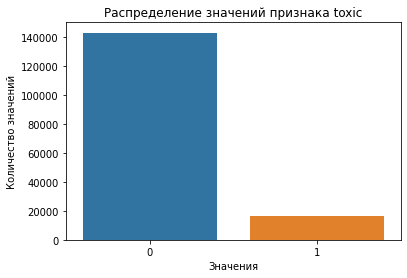

In [ ]:
# посмотрим, требуется ли стратификация выборки
sns.barplot(
    x=toxic_comments['toxic'].unique(), y=toxic_comments['toxic'].value_counts()
)

plt.title(f'Распределение значений признака toxic')
plt.xlabel('Значения')
plt.ylabel('Количество значений')

pass

Классы не сбалансированы. Проведем стратификацию при разделении данных в одном из следующих разделов.

### Подготовка данных

In [ ]:
# создание корпуса текстов
corpus = toxic_comments['text'].values
corpus

array(["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
       "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
       "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",
       ...,
       'Spitzer \n\nUmm, theres no actual article for prostitution ring.  - Crunch Captain.',
       'And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.',
       '"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of communit

In [ ]:
# установка averaged_perceptron_tagger для использования в функции pos_tag()
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
# очистка текста с помощью регулярных выражений, удаление заглавных символов
# лемматизация английского текста
lemmatizer = WordNetLemmatizer()

def penn2morphy(penntag):
    # конвертируем Penn Treebank tags to WordNet
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

def lemmatize_sent(text):
    text_clean = re.sub(r'[^a-zA-Z\' ]+', ' ', text)

    return ' '.join([lemmatizer.lemmatize(word.lower(), pos=penn2morphy(tag))
                     for word, tag in pos_tag(nltk.word_tokenize(text_clean))])

lemmatize_sent(corpus[0])

"explanation why the edits make under my username hardcore metallica fan be revert they be n't vandalisms just closure on some gas after i vote at new york doll fac and please do n't remove the template from the talk page since i 'm retired now"

In [ ]:
tqdm.pandas()
toxic_comments['prepaired'] = toxic_comments['text'].progress_apply(lemmatize_sent)
toxic_comments

  0%|          | 0/159292 [00:00<?, ?it/s]

,Unnamed: 0,text,toxic,prepaired
0,0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,1,D'aww! He matches this background colour I'm s...,0,d'aww he match this background colour i 'm see...
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man i 'm really not try to edit war it 's ...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,more i ca n't make any real suggestion on impr...
4,4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...
...,...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0,and for the second time of ask when your view ...
159288,159447,You should be ashamed of yourself \n\nThat is ...,0,you should be ashamed of yourself that be a ho...
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm theres no actual article for prost...
159290,159449,And it looks like it was actually you who put ...,0,and it look like it be actually you who put on...


In [ ]:
# исключение стоп-слов
nltk.download('stopwords')
stopwords = list(set(nltk_stopwords.words('english')))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# разбивка данных
X = toxic_comments['prepaired']
y = toxic_comments['toxic']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE,
    stratify=y
)

С целью устранения утечки данных, векторизацию предобработанного корпуса текстов проведем с помощью пайплайна на следующем этапе проекта.

### Выводы

Данные загружены и изучены.<br>
Произведена подготовка данных для дальнейшего моделирования:<br>
- с помощью шаблонов преобразован текст (удалены лишние символы, текст приведен к нижнему регистру);
- произведена лемматизация корпуса текстов;
- произведена разбивка выборки на тренировочную и тестовую (в т.ч. поизведена стратификация выборки из-за дисбаланса меток целевого признака);
- корпус текстов преобразован в векторы, из которых удалены стоп-слова.

## Обучение моделей

### Модели с использованием векторных представлений, полученных с помощью TF-IDF

In [ ]:
# создание пайплайна из векторайзера и модели
pipeline = Pipeline(
    [
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('models', LogisticRegression())
    ]
)

In [ ]:
# словарь для модели LogisticRegression
param_grid_lr = [
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__penalty': ['l1', 'l2'],
        'models__C': range(1,10,1)
    }
]

# словарь для модели DecisionTreeClassifier
param_grid_dtc = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__min_samples_leaf': [1, 2],
        'models__max_depth': [20, 60]
    }
]

In [ ]:
%%time
# Логистическая регрессия. Подбор гиперпараметров
randomized_search_lr = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid_lr,
    cv=3,
    n_jobs=-1,
    scoring='f1',
    verbose=False
)

randomized_search_lr.fit(X_train, y_train)

print(
    'Модель с лучшими гиперпараметрами и её параметры:\n\n',
    randomized_search_lr.best_params_
)
print (
    'Метрика модели при кросс-валидации:',
    randomized_search_lr.best_score_
)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

Модель с лучшими гиперпараметрами и её параметры:

 {'models__penalty': 'l2', 'models__C': 9, 'models': LogisticRegression(C=9, random_state=42)}
Метрика модели при кросс-валидации: 0.7669423245997585
CPU times: user 7min 52s, sys: 5min 39s, total: 13min 31s
Wall time: 13min 32s


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
%%time
# Дерево решений. Подбор гиперпараметров
randomized_search_dtc = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid_dtc,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=False
)
randomized_search_dtc.fit(X_train, y_train)

print(
    'Модель с лучшими гиперпараметрами и её параметры:\n\n',
    randomized_search_dtc.best_params_
)
print (
    'Метрика модели при кросс-валидации:',
    randomized_search_dtc.best_score_
)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Модель с лучшими гиперпараметрами и её параметры:

 {'models__min_samples_leaf': 1, 'models__max_depth': 60, 'models': DecisionTreeClassifier(max_depth=60, random_state=42)}
Метрика модели при кросс-валидации: 0.7043964434064076
CPU times: user 4min 48s, sys: 0 ns, total: 4min 48s
Wall time: 4min 48s


### Модели с использованием векторных представлений, полученных с помощью нейросети BERT

In [ ]:
 # выделение случайных 800 текстов для ускорения работы кода
toxic_comments_sample = toxic_comments.sample(800).reset_index(drop=True)

In [ ]:
'''
Инициализация токенизатора с помощью предобученной модели.
Используем модель unitary/toxic-bert. Она обучена на определение токсичности
'''
tokenizer = transformers.BertTokenizer.from_pretrained('unitary/toxic-bert')
# преобразование текста в номера токенов
tokenized = toxic_comments_sample['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True)
)

Параметр truncation=True использован для исключения токенов, размер которых превышет максимальную длину в количестве токенов для входов в модель преобразователя

In [ ]:
# определение максимальной длины вектора для дальнейшего использования в методе padding
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

# применение метода padding
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)

Метод padding применяется для того, чтобы после токенизации длины исходных текстов в корпусе были равными (только при таком условии будет работать модель BERT).

In [ ]:
# инициализация модели BertModel
model = transformers.BertModel.from_pretrained('unitary/toxic-bert')

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
'''# создание эмбеддингов
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
        attention_mask_batch = torch.LongTensor(
            attention_mask[batch_size*i:batch_size*(i+1)]
        )

        with torch.no_grad():
            batch_embeddings = model(
                batch, attention_mask=attention_mask_batch
            )

        embeddings.append(batch_embeddings[0][:,0,:].numpy())

features = np.concatenate(embeddings)'''

'# создание эмбеддингов\nbatch_size = 100\nembeddings = []\nfor i in notebook.tqdm(range(padded.shape[0] // batch_size)):\n        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])\n        attention_mask_batch = torch.LongTensor(\n            attention_mask[batch_size*i:batch_size*(i+1)]\n        )\n\n        with torch.no_grad():\n            batch_embeddings = model(\n                batch, attention_mask=attention_mask_batch\n            )\n\n        embeddings.append(batch_embeddings[0][:,0,:].numpy())\n\nfeatures = np.concatenate(embeddings)'

In [ ]:
# создание эмбеддингов

# объявляем переменную, где будет храниться ссылка на видеокарту при её наличии
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device) # модельку отправляем на GPU

# уменьшаем размер батча для работы с GPU
batch_size = 16
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])

        with torch.no_grad():
            batch_embeddings = model(
                batch.to(device), # на GPU
                attention_mask=attention_mask_batch.to(device)# на GPU
            )

        embeddings.append(batch_embeddings[0][:,0,:]
                          .cpu()  # результат возвращаем на CPU
                          .numpy()
                         )

features = np.concatenate(embeddings)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# разбивка на тренировочную и тестовую выборки
X_bert = features
y_bert = toxic_comments_sample['toxic']

X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    X_bert,
    y_bert,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_bert
    )

In [ ]:
print('Размер признаков из BERT:', features.shape)
print('Размер целевого признака:', y_bert.shape)

Размер признаков из BERT: (800, 768)
Размер целевого признака: (800,)


In [ ]:
# Логистическая регрессия с эмбеддингами, полученными с помощью модели BERT
model_lr_bert = LogisticRegression(random_state=RANDOM_STATE)

param_grid_lr_bert = {
        'penalty': ['l1', 'l2'],
        'C': range(1,10,1)
    }

randomized_search_lr_bert = RandomizedSearchCV(
    estimator=model_lr_bert,
    param_distributions=param_grid_lr_bert,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)
randomized_search_lr_bert.fit(X_train_bert, y_train_bert)

print('Модель с лучшими гиперпараметрами и её параметры:\n\n', randomized_search_lr_bert.best_params_)
print ('Метрика модели при кросс-валидации:', randomized_search_lr_bert.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................................C=8, penalty=l2; total time=   0.4s


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................................C=8, penalty=l2; total time=   0.6s


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................................C=8, penalty=l2; total time=   0.5s


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................................C=1, penalty=l2; total time=   0.7s


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................................C=1, penalty=l2; total time=   0.6s
[CV] END ....................................C=1, penalty=l2; total time=   1.0s
[CV] END ....................................C=6, penalty=l1; total time=   0.1s
[CV] END ....................................C=6, penalty=l1; total time=   0.0s
[CV] END ....................................C=6, penalty=l1; total time=   0.0s
[CV] END ....................................C=2, penalty=l1; total time=   0.0s
[CV] END ....................................C=2, penalty=l1; total time=   0.0s
[CV] END ....................................C=2, penalty=l1; total time=   0.0s
[CV] END ....................................C=8, penalty=l1; total time=   0.0s
[CV] END ....................................C=8, penalty=l1; total time=   0.1s
[CV] END ....................................C=8, penalty=l1; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: Fi

[CV] END ....................................C=7, penalty=l2; total time=   0.8s


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................................C=7, penalty=l2; total time=   0.6s


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................................C=7, penalty=l2; total time=   0.6s


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................................C=5, penalty=l2; total time=   0.6s


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................................C=5, penalty=l2; total time=   0.6s


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logisti

[CV] END ....................................C=5, penalty=l2; total time=   0.6s
[CV] END ....................................C=4, penalty=l1; total time=   0.0s
[CV] END ....................................C=4, penalty=l1; total time=   0.0s
[CV] END ....................................C=4, penalty=l1; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................................C=9, penalty=l2; total time=   0.6s


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................................C=9, penalty=l2; total time=   0.5s


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logisti

[CV] END ....................................C=9, penalty=l2; total time=   0.6s
[CV] END ....................................C=7, penalty=l1; total time=   0.1s
[CV] END ....................................C=7, penalty=l1; total time=   0.0s
[CV] END ....................................C=7, penalty=l1; total time=   0.0s
Модель с лучшими гиперпараметрами и её параметры:

 {'penalty': 'l2', 'C': 1}
Метрика модели при кросс-валидации: 0.9032567049808429


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Дерево решений с эмбеддингами, полученными с помощью модели BERT
model_dtc_bert = DecisionTreeClassifier(random_state=RANDOM_STATE)

param_grid_dtc_bert = {
        'min_samples_leaf': [1, 2],
        'max_depth': [20, 60]
    }

randomized_search_dtc_bert = RandomizedSearchCV(
    estimator=model_dtc_bert,
    param_distributions=param_grid_dtc_bert,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)
randomized_search_dtc_bert.fit(X_train_bert, y_train_bert)

print('Модель с лучшими гиперпараметрами и её параметры:\n\n', randomized_search_dtc_bert.best_params_)
print ('Метрика модели при кросс-валидации:', randomized_search_dtc_bert.best_score_)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ...................max_depth=20, min_samples_leaf=1; total time=   0.2s
[CV] END ...................max_depth=20, min_samples_leaf=1; total time=   0.1s
[CV] END ...................max_depth=20, min_samples_leaf=1; total time=   0.1s
[CV] END ...................max_depth=20, min_samples_leaf=2; total time=   0.1s
[CV] END ...................max_depth=20, min_samples_leaf=2; total time=   0.1s
[CV] END ...................max_depth=20, min_samples_leaf=2; total time=   0.1s
[CV] END ...................max_depth=60, min_samples_leaf=1; total time=   0.1s
[CV] END ...................max_depth=60, min_samples_leaf=1; total time=   0.1s
[CV] END ...................max_depth=60, min_samples_leaf=1; total time=   0.1s
[CV] END ...................max_depth=60, min_samples_leaf=2; total time=   0.1s
[CV] END ...................max_depth=60, min_samples_leaf=2; total time=   0.1s
[CV] END ...................max_depth=60, min_sam

In [ ]:
# проверка модели на адекватность с помощью модели DummyClassifier
model_dummy = DummyClassifier(strategy='uniform', random_state=RANDOM_STATE)

model_dummy.fit(X_train, y_train)
preds_dummy = model_dummy.predict(X_test)
f1_dummy = f1_score(y_test, preds_dummy)
print('Метрика f1 dummy-модели:', round(f1_dummy, 3))

Метрика f1 dummy-модели: 0.166


In [ ]:
print (
    'Метрика модели LogisticRegression (векторные представления'
    'получены с помощью TF-IDF) при кросс-валидации:',
    round(randomized_search_lr.best_score_, 3)
)
print (
    'Метрика модели LogisticRegression (векторные представления'
    'получены с помощью нейросети BERT) при кросс-валидации:',
    round(randomized_search_lr_bert.best_score_, 3), '\n'
)

print (
    'Метрика модели DecisionTreeClassifier (векторные представления'
    'получены с помощью TF-IDF) при кросс-валидации:',
    round(randomized_search_dtc.best_score_, 3)
)
print (
    'Метрика модели DecisionTreeClassifier (векторные представления'
    'получены с помощью нейросети BERT) при кросс-валидации:',
    round(randomized_search_dtc_bert.best_score_, 3)
)

Метрика модели LogisticRegression (векторные представленияполучены с помощью TF-IDF) при кросс-валидации: 0.767
Метрика модели LogisticRegression (векторные представленияполучены с помощью нейросети BERT) при кросс-валидации: 0.903 

Метрика модели DecisionTreeClassifier (векторные представленияполучены с помощью TF-IDF) при кросс-валидации: 0.704
Метрика модели DecisionTreeClassifier (векторные представленияполучены с помощью нейросети BERT) при кросс-валидации: 0.809


Модели, обученные с помощью BERT (с использованием предобученной модели unitary/toxic-bert, которая предназначена специально для целей определения токсичности) показали лучшие метрики, чем модели, обученные с использованием TF-IDF.<br> В качестве лучшей модели выберем модель LogisticRegression  (BERT), т.к. она имеет лучшую метрику f1.

In [ ]:
# предсказания лучшей модели на тестовой выборке
print('Метрика f1 лучшей модели на тестовой выборке', f1_score(y_test_bert, randomized_search_dtc_bert.predict(X_test_bert)))

Метрика f1 лучшей модели на тестовой выборке 0.8421052631578948


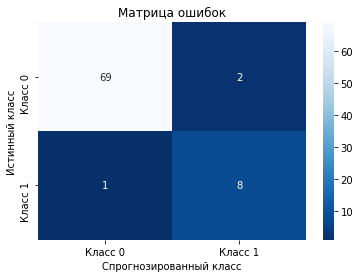

In [ ]:
# построим матрицу ошибок
tick_labels = [f'Класс {i}' for i in range(0,2)]

cm = confusion_matrix(
    y_test_bert,
    randomized_search_dtc_bert.predict(X_test_bert)
)
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues_r',
    xticklabels=tick_labels,
    yticklabels=tick_labels
)
plt.title('Матрица ошибок')
plt.ylabel('Истинный класс')
plt.xlabel('Спрогнозированный класс')

pass

### Выводы

На данном этапе были обучены модели с использованием векторных представлений, полученных с помощью TF-IDF и BERT:
- логистическая регрессия;
- дерево решений.<br><br>
В качестве лучшей модели выбрана LogisticRegression (BERT) с метрикой f1 равной:
-  на тренировочной выборке 0.9;
- на тестовой выборке 0.84.

## Общие выводы

В настоящем проекте были обучены модели с использованием векторных представлений, полученных с помощью TF-IDF и BERT, с целью классификации комментариев на положительные и негативные:
- логистическая регрессия;
- дерево решений.<br><br>
В качестве лучшей модели выбрана LogisticRegression (BERT) с метрикой f1 равной:
-  на тренировочной выборке 0.9;
- на тестовой выборке 0.84.
Значения метрик соответствуют условию задачи: f1 должен быть не меньше 0.75.